In [26]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from scipy.stats import linregress
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

# Define the project root directory
ROOT_DIR = os.path.join(os.getcwd(), os.pardir)

In [7]:
# Load the data
df = pd.read_pickle(f"{ROOT_DIR}/data/data.csv")
print(f"Loaded raw data of shape {df.shape}")

Loaded raw data of shape (1892, 14)


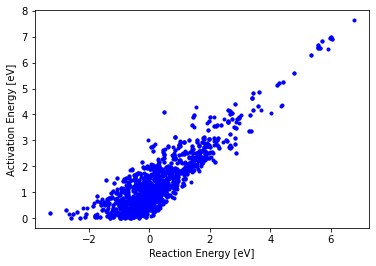

(1892, 14)

In [8]:
plt.plot(df["Reaction Energy"], df["Activation Energy"], "b.")
plt.xlabel("Reaction Energy [eV]")
plt.ylabel("Activation Energy [eV]")
plt.savefig(f"{ROOT_DIR}/data/images/er_ea_correlation.png")
plt.show()
df.shape

### Separate metals, non-metals, and semiconductors

In [10]:
metals = [
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd",
    "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn",
    "Al", "Ga", "In", "Sn", "Tl", "Pb", "Bi", "Nh", "Fl", "Mc", "Lv",
    "Y-fcc", "Zr-fcc", "Nb-fcc", "Mo-fcc", "Tc-fcc", "Ru-fcc", "Rh-fcc", "Pd-fcc", "Ag-fcc", "Cd-fcc",
    "Sc-fcc", "Ti-fcc", "V-fcc", "Cr-fcc", "Mn-fcc", "Fe-fcc", "Co-fcc", "Ni-fcc", "Cu-fcc", "Zn-fcc",
    "Hf-fcc", "Ta-fcc", "W-fcc", "Re-fcc", "Os-fcc", "Ir-fcc", "Pt-fcc", "Au-fcc", "Hg-fcc",
    "Rf-fcc", "Db-fcc", "Sg-fcc", "Bh-fcc", "Hs-fcc", "Mt-fcc", "Ds-fcc", "Rg-fcc", "Cn-fcc",
    "Al-fcc", "Ga-fcc", "In-fcc", "Sn-fcc", "Tl-fcc", "Pb-fcc", "Bi-fcc", "Nh-fcc", "Fl-fcc", "Mc-fcc", "Lv-fcc"
]

indices = []

for i in range(df.shape[0]):
    if df.iloc[i]["Chemical Composition"] in metals or df.iloc[i]["Surface Composition"] in metals:
        indices.append(i)
df = df.iloc[indices]

print(f"Found {df.shape[0]} reaction on pure metal catalyst surfaces.")

Found 1826 reaction on pure metal catalyst surfaces.


### Transform feature labels to binary one-hot arrays with DataFrameMapper and LabelBinarizer

In [13]:
df_bin = df.copy()
print(f"Converted {df_bin.shape[1] - 1} features into ", end="")

bin_mapper = DataFrameMapper([
    ("Reactant 1", LabelBinarizer()),
    ("Reactant 2", LabelBinarizer()),
    ("Reactant 3", LabelBinarizer()),
    ("Product 1", LabelBinarizer()),
    ("Product 2", LabelBinarizer()),
    ("Chemical Composition", LabelBinarizer()),
    ("Surface Composition", LabelBinarizer()),
    ("Facet", LabelBinarizer()),
    ("Adsorption Site", LabelBinarizer()),
    ("Reaction Equation", LabelBinarizer()),
    (["Reaction Energy"], None),
    (["Activation Energy"], None),
], df_out=True)

df_bin = bin_mapper.fit_transform(df_bin)
print(f"{df_bin.shape[1] - 1} features.")
df_bin.head()

Converted 13 features into 527 features.


,Reactant 1_*,Reactant 1_C*,Reactant 1_CCH*,Reactant 1_CCH2*,Reactant 1_CCH3*,Reactant 1_CH*,Reactant 1_CH2*,Reactant 1_CH2CH2*,Reactant 1_CH2CH3*,Reactant 1_CH2N*,...,Reaction Equation_O2(g) -> O*,Reaction Equation_O2* -> O*,Reaction Equation_OCCO* + 0.5H2(g) -> OCCOH*,Reaction Equation_OCH* -> CH* + O*,Reaction Equation_OCH2* -> CH2* + O*,Reaction Equation_OCH3* -> CH3* + O*,Reaction Equation_OH* + * -> H* + O*,Reaction Equation_OH* -> H* + O*,Reaction Energy,Activation Energy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.584128,2.079705
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.520276,0.618718
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.701011,4.165724
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.350000,2.550000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.353636,0.482330


### OR Transform feature labels to integer values with LabelEncoder

In [14]:
df_enc = df.copy()

enc_mapper = DataFrameMapper([
    ('Reactant 1', LabelEncoder()),
    ('Reactant 2', LabelEncoder()),
    ('Reactant 3', LabelEncoder()),
    ('Product 1', LabelEncoder()),
    ('Product 2', LabelEncoder()),
    ('Chemical Composition', LabelEncoder()),
    ('Surface Composition', LabelEncoder()),
    ('Facet', LabelEncoder()),
    ('Adsorption Site', LabelEncoder()),
    ('Reaction Equation', LabelEncoder()),
    (['Reaction Energy'], None),
    (['Activation Energy'], None),
], df_out=True)

df_enc = enc_mapper.fit_transform(df_enc)
df_enc = df_enc.drop_duplicates(ignore_index=True)
df_enc.head()

,Reactant 1,Reactant 2,Reactant 3,Product 1,Product 2,Chemical Composition,Surface Composition,Facet,Adsorption Site,Reaction Equation,Reaction Energy,Activation Energy
0,44,46,5,73,0,31,19,6,5,129,1.584128,2.079705
1,0,46,5,0,42,31,19,6,5,117,0.520276,0.618718
2,0,10,5,2,5,2,0,6,5,22,3.701011,4.165724
3,51,58,5,51,52,43,19,7,5,137,1.350000,2.550000
4,32,58,5,33,52,6,2,7,0,109,0.353636,0.482330


### Split the data into training and test sets

In [15]:
train_set_enc, test_set_enc = train_test_split(df_enc, test_size=0.2)
train_set_bin, test_set_bin = train_test_split(df_bin, test_size=0.2)

y_train_enc = train_set_enc["Activation Energy"]
X_train_enc = train_set_enc.drop("Activation Energy", axis=1)
y_train_bin = train_set_bin["Activation Energy"]
X_train_bin = train_set_bin.drop("Activation Energy", axis=1)

y_test_enc = test_set_enc["Activation Energy"]
X_test_enc = test_set_enc.drop("Activation Energy", axis=1)
y_test_bin = test_set_bin["Activation Energy"]
X_test_bin = test_set_bin.drop("Activation Energy", axis=1)

### Kernel Ridge Regression

In [18]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "gamma": np.logspace(-2, 2, 5),
              "kernel": ["rbf", "linear"]}

krr_enc = GridSearchCV(KRR(), param_grid=param_grid)
krr_enc.fit(X_train_enc, y_train_enc)
krr_enc_best = krr_enc.best_estimator_
krr_enc_score = krr_enc_best.score(X_test_enc, y_test_enc)
krr_enc_pred = krr_enc_best.predict(X_test_enc)

krr_bin = GridSearchCV(KRR(), param_grid=param_grid)
krr_bin.fit(X_train_bin, y_train_bin)
krr_bin_best = krr_bin.best_estimator_
krr_bin_score = krr_bin_best.score(X_test_bin, y_test_bin)
krr_bin_pred = krr_bin_best.predict(X_test_bin)

print(f"KRR score with label encoded data: {krr_enc_score}, using parameters: {krr_enc_best.get_params()}")
print(f"KRR score with label binarized data: {krr_bin_score}, using parameters: {krr_bin_best.get_params()}")

KRR score with label encoded data: 0.7344589224984097, using parameters: {'alpha': 1.0, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'linear', 'kernel_params': None}
KRR score with label binarized data: 0.9508332111666689, using parameters: {'alpha': 0.01, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'kernel_params': None}


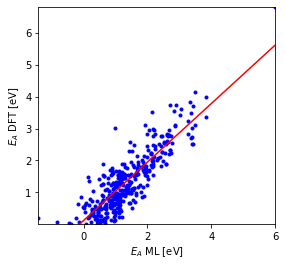

In [45]:
# Plot the label encoded KRR predictions against the test set target values

res = linregress(krr_enc_pred, y_test_enc)
x = np.arange(-1, 8, 1)
y = x*res[0] + res[1]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(krr_enc_pred, y_test_enc, "b.")
plt.plot(x, y, "r-")
plt.xlabel("$E_A$ ML [eV]")
plt.ylabel("$E_A$ DFT [eV]")
plt.xlim(xmin=min(krr_enc_pred), xmax=max(krr_enc_pred))
plt.ylim(ymin=min(y_test_enc), ymax=max(y_test_enc))
ax.set_aspect("equal")
plt.savefig(f"{ROOT_DIR}/data/images/krr_enc_pred.png")
plt.show()

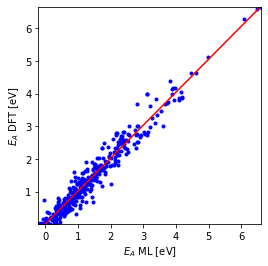

In [46]:
# Plot the binarized KRR predictions against the test set target values

res = linregress(krr_bin_pred, y_test_bin)
x = np.arange(0, 8, 1)
y = x*res[0] + res[1]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(krr_bin_pred, y_test_bin, "b.")
plt.plot(x, y, "r-")
plt.xlabel("$E_A$ ML [eV]")
plt.ylabel("$E_A$ DFT [eV]")
plt.xlim(xmin=min(krr_bin_pred), xmax=max(krr_bin_pred))
plt.ylim(ymin=min(y_test_bin), ymax=max(y_test_bin))
ax.set_aspect("equal")
plt.savefig(f"{ROOT_DIR}/data/images/krr_bin_pred.png")
plt.show()

### Random Forest

In [47]:
n_estimators = [50, 100, 150, 200, 250, 300]
max_features = ["auto", "sqrt", "log2"]
max_depth = [10, 20, 30, 40]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10, 15, 20]

param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf
}

rfr_enc = RandomizedSearchCV(RFR(), param_distributions=param_grid, n_iter=400, cv=5, verbose=1, n_jobs=-1)
rfr_enc.fit(X_train_enc, y_train_enc)

rfr_bin = RandomizedSearchCV(RFR(), param_distributions=param_grid, n_iter=400, cv=5, verbose=1, n_jobs=-1)
rfr_bin.fit(X_train_bin, y_train_bin)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Fitting 5 folds for each of 400 candidates, totalling 2000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=400,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   verbose=1)

In [48]:
rfr_enc_best = rfr_enc.best_estimator_
rfr_enc_score = rfr_enc_best.score(X_test_enc, y_test_enc)
rfr_enc_pred = rfr_enc_best.predict(X_test_enc)

rfr_bin_best = rfr_bin.best_estimator_
rfr_bin_score = rfr_bin_best.score(X_test_bin, y_test_bin)
rfr_bin_pred = rfr_bin_best.predict(X_test_bin)

print(f"Random Forest score with label encoded data: {rfr_enc_score}, using parameters: {rfr_enc_best.get_params()}")
print(f"Random Forest score with label binarized data: {rfr_bin_score}, using parameters: {rfr_bin_best.get_params()}")

Random Forest score with label encoded data: 0.9045524895605336, using parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Random Forest score with label binarized data: 0.9052001179537059, using parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


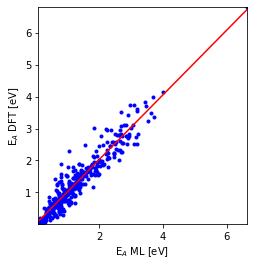

In [54]:
res = linregress(rfr_enc_pred, y_test_enc)
x = np.arange(0, 8, 1)
y = x*res[0] + res[1]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(rfr_enc_pred, y_test_enc, "b.")
plt.plot(x, y, "r-")
plt.xlabel("E$_A$ ML [eV]")
plt.ylabel("E$_A$ DFT [eV]")
plt.xlim(xmin=min(rfr_enc_pred), xmax=max(rfr_enc_pred))
plt.ylim(ymin=min(y_test_enc), ymax=max(y_test_enc))
ax.set_aspect("equal")
plt.savefig(f"{ROOT_DIR}/data/images/rfr_enc_pred.png")
plt.show()

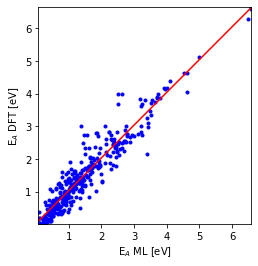

In [55]:
res = linregress(rfr_bin_pred, y_test_bin)
x = np.arange(0, 8, 1)
y = x*res[0] + res[1]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(rfr_bin_pred, y_test_bin, "b.")
plt.plot(x, y, "r-")
plt.xlabel("E$_A$ ML [eV]")
plt.ylabel("E$_A$ DFT [eV]")
plt.xlim(xmin=min(rfr_bin_pred), xmax=max(rfr_bin_pred))
plt.ylim(ymin=min(y_test_bin), ymax=max(y_test_bin))
ax.set_aspect("equal")
plt.savefig(f"{ROOT_DIR}/data/images/rfr_bin_pred.png")
plt.show()

### Save the trained models

In [58]:
# Save the label encoded RFR model
with open(f"{ROOT_DIR}/data/rfr_enc.pkl", "wb") as rfr_enc_file:
    pickle.dump(rfr_enc_best, rfr_enc_file)
    
# Save the label binarized RFR model
with open(f"{ROOT_DIR}/data/rfr_bin.pkl", "wb") as rfr_bin_file:
    pickle.dump(rfr_bin_best, rfr_bin_file)
    
# Save the label encoded KRR model
with open(f"{ROOT_DIR}/data/krr_enc.pkl", "wb") as krr_enc_file:
    pickle.dump(krr_enc_best, krr_enc_file)
    
# Save the label binarized KRR model
with open(f"{ROOT_DIR}/data/krr_bin.pkl", "wb") as krr_bin_file:
    pickle.dump(krr_bin_best, krr_bin_file)

## Inspect the freature importances

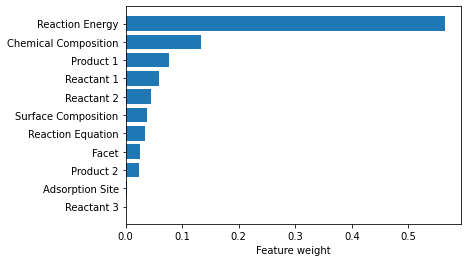

In [57]:
fimportances = rfr_enc_best.feature_importances_
fi_data = np.array([X_train_enc.columns,fimportances]).T
fi_data = fi_data[fi_data[:,1].argsort()]

plt.barh(fi_data[:,0], fi_data[:,1])
plt.xlabel("Feature weight")
plt.savefig(f"{ROOT_DIR}/data/images/feature_importances.png", bbox_inches="tight")
plt.show()